In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix, 
                             roc_auc_score, roc_curve, precision_recall_curve)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# 1. DATA LOADING & EXPLORATION
credit_data = pd.read_csv(r"C:\Users\udayk\OneDrive\B_A (analyst)\Logistic_Regression\credit-risk-prediction\credit_risk_dataset.csv")
print(f"Dataset Shape: {credit_data.shape}")
print(f"\nColumns: {credit_data.columns.tolist()}")
print(f"\nMissing Values:\n{credit_data.isna().sum()}")
print(f"\nClass Distribution:\n{credit_data['loan_status'].value_counts()}")
print(f"Default Rate: {credit_data['loan_status'].mean():.2%}")

Dataset Shape: (32581, 12)

Columns: ['person_age', 'person_income', 'person_home_ownership', 'person_emp_length', 'loan_intent', 'loan_grade', 'loan_amnt', 'loan_int_rate', 'loan_status', 'loan_percent_income', 'cb_person_default_on_file', 'cb_person_cred_hist_length']

Missing Values:
person_age                       0
person_income                    0
person_home_ownership            0
person_emp_length              895
loan_intent                      0
loan_grade                       0
loan_amnt                        0
loan_int_rate                 3116
loan_status                      0
loan_percent_income              0
cb_person_default_on_file        0
cb_person_cred_hist_length       0
dtype: int64

Class Distribution:
loan_status
0    25473
1     7108
Name: count, dtype: int64
Default Rate: 21.82%


In [ ]:

# 2. DATA CLEANING & OUTLIER REMOVAL


# Remove invalid employment lengths
credit_data = credit_data[
    (credit_data['person_emp_length'] <= credit_data['person_age'] - 18) &
    (credit_data['person_emp_length'] >= 0)
]


credit_data = credit_data[
    (credit_data['person_age'] >= 18) &
    (credit_data['person_age'] <= 80)
]


In [ ]:
Q1 = credit_data['person_emp_length'].quantile(0.25)
Q3 = credit_data['person_emp_length'].quantile(0.75)
IQR = Q3 - Q1
credit_data = credit_data[
    credit_data['person_emp_length'] <= Q3 + 1.5 * IQR
]

# Handle missing values in loan_int_rate (if any)
if credit_data['loan_int_rate'].isna().sum() > 0:
    credit_data['loan_int_rate'].fillna(credit_data['loan_int_rate'].median(), inplace=True)

print(f"\nCleaned Dataset Shape: {credit_data.shape}")


Cleaned Dataset Shape: (23050, 12)


In [ ]:
# 3. ADVANCED FEATURE ENGINEERING


# Debt-to-Income Ratio (critical for lending)
credit_data['debt_to_income'] = credit_data['loan_amnt'] / (credit_data['person_income'] + 1)

# Income to Loan Ratio
credit_data['income_to_loan'] = credit_data['person_income'] / (credit_data['loan_amnt'] + 1)

# Age groups (life stages matter for credit risk)
credit_data['age_group'] = pd.cut(credit_data['person_age'],
                                   bins=[0, 25, 35, 50, 100],
                                   labels=['young', 'middle', 'senior', 'elderly'])

# Employment stability score
credit_data['emp_stability'] = credit_data['person_emp_length'] / (credit_data['person_age'] + 1)

# High risk loan indicator (interest rate above median)
median_rate = credit_data['loan_int_rate'].median()
credit_data['high_interest'] = (credit_data['loan_int_rate'] > median_rate).astype(int)

# Credit utilization indicator
credit_data['high_utilization'] = (credit_data['loan_percent_income'] > 0.3).astype(int)

# Encode categorical variables
label_encoders = {}
categorical_cols = ['person_home_ownership', 'loan_intent', 'loan_grade',
                   'cb_person_default_on_file', 'age_group']

for col in categorical_cols:
    if col in credit_data.columns:
        le = LabelEncoder()
        credit_data[col + '_encoded'] = le.fit_transform(credit_data[col].astype(str))
        label_encoders[col] = le

print(f"\nFeature Engineering Complete. Total Features: {credit_data.shape[1]}")


Feature Engineering Complete. Total Features: 23


In [ ]:
feature_cols = ['person_age', 'person_income', 'person_emp_length',
                'loan_amnt', 'loan_int_rate', 'loan_percent_income',
                'cb_person_cred_hist_length', 'debt_to_income',
                'income_to_loan', 'emp_stability', 'high_interest',
                'high_utilization']

# Add encoded categorical features
for col in categorical_cols:
    if col + '_encoded' in credit_data.columns:
        feature_cols.append(col + '_encoded')

X = credit_data[feature_cols]
y = credit_data['loan_status']

print(f"\nSelected Features: {len(feature_cols)}")
print(f"Features: {feature_cols}")



Selected Features: 17
Features: ['person_age', 'person_income', 'person_emp_length', 'loan_amnt', 'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length', 'debt_to_income', 'income_to_loan', 'emp_stability', 'high_interest', 'high_utilization', 'person_home_ownership_encoded', 'loan_intent_encoded', 'loan_grade_encoded', 'cb_person_default_on_file_encoded', 'age_group_encoded']


In [ ]:
# split the data into features(X) and labels(y) 
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"\nTraining Set: {X_train.shape[0]} samples")
print(f"Test Set: {X_test.shape[0]} samples")
print(f"Train Default Rate: {y_train.mean():.2%}")
print(f"Test Default Rate: {y_test.mean():.2%}")


Training Set: 18440 samples
Test Set: 4610 samples
Train Default Rate: 22.84%
Test Default Rate: 22.84%


In [ ]:
smote = SMOTE(random_state=42, k_neighbors=5)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_scaled, y_train)

print(f"\nAfter SMOTE:")
print(f"Training samples: {X_train_balanced.shape[0]}")
print(f"Class distribution: {np.bincount(y_train_balanced)}")


After SMOTE:
Training samples: 28458
Class distribution: [14229 14229]


In [ ]:
# train the model
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
    'XGBoost': XGBClassifier(n_estimators=100, random_state=42, eval_metric='logloss')
}

results = {}

print("\n" + "="*70)
print("MODEL COMPARISON")
print("="*70)

for name, model in models.items():
    # Train on balanced data
    model.fit(X_train_balanced, y_train_balanced)

    # Predict on test set
    y_pred = model.predict(X_test_scaled)
    y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)

    # Cross-validation on original training data
    cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='roc_auc')

    results[name] = {
        'model': model,
        'accuracy': accuracy,
        'roc_auc': roc_auc,
        'cv_mean': cv_scores.mean(),
        'cv_std': cv_scores.std(),
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba
    }

    print(f"\n{name}:")
    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  ROC-AUC: {roc_auc:.4f}")
    print(f"  CV Score: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")
    print(f"\n{classification_report(y_test, y_pred, target_names=['No Default', 'Default'])}")

# Select best model based on ROC-AUC
best_model_name = max(results, key=lambda x: results[x]['roc_auc'])
best_model = results[best_model_name]['model']
print(f"\n{'='*70}")
print(f"BEST MODEL: {best_model_name} (ROC-AUC: {results[best_model_name]['roc_auc']:.4f})")
print(f"{'='*70}")


MODEL COMPARISON

Logistic Regression:
  Accuracy: 0.8208
  ROC-AUC: 0.8821
  CV Score: 0.8769 (+/- 0.0043)

              precision    recall  f1-score   support

  No Default       0.93      0.83      0.88      3557
     Default       0.58      0.78      0.67      1053

    accuracy                           0.82      4610
   macro avg       0.75      0.81      0.77      4610
weighted avg       0.85      0.82      0.83      4610


Random Forest:
  Accuracy: 0.9312
  ROC-AUC: 0.9351
  CV Score: 0.9310 (+/- 0.0022)

              precision    recall  f1-score   support

  No Default       0.93      0.98      0.96      3557
     Default       0.93      0.75      0.83      1053

    accuracy                           0.93      4610
   macro avg       0.93      0.87      0.90      4610
weighted avg       0.93      0.93      0.93      4610


Gradient Boosting:
  Accuracy: 0.9145
  ROC-AUC: 0.9316
  CV Score: 0.9316 (+/- 0.0046)

              precision    recall  f1-score   support

  No 

In [ ]:
if best_model_name == 'XGBoost':
    param_grid = {
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.1, 0.3],
        'n_estimators': [100, 200],
        'min_child_weight': [1, 3, 5]
    }

    grid_search = GridSearchCV(
        XGBClassifier(random_state=42, eval_metric='logloss'),
        param_grid, cv=3, scoring='roc_auc', n_jobs=-1, verbose=1
    )

    print("\nPerforming Hyperparameter Tuning...")
    grid_search.fit(X_train_balanced, y_train_balanced)

    best_model = grid_search.best_estimator_
    print(f"\nBest Parameters: {grid_search.best_params_}")
    print(f"Best CV Score: {grid_search.best_score_:.4f}")

    # Re-evaluate with tuned model
    y_pred_final = best_model.predict(X_test_scaled)
    y_pred_proba_final = best_model.predict_proba(X_test_scaled)[:, 1]

    print(f"\nTuned Model Performance:")
    print(f"Accuracy: {accuracy_score(y_test, y_pred_final):.4f}")
    print(f"ROC-AUC: {roc_auc_score(y_test, y_pred_proba_final):.4f}")
    print(f"\n{classification_report(y_test, y_pred_final, target_names=['No Default', 'Default'])}")


Performing Hyperparameter Tuning...
Fitting 3 folds for each of 54 candidates, totalling 162 fits

Best Parameters: {'learning_rate': 0.3, 'max_depth': 7, 'min_child_weight': 1, 'n_estimators': 200}
Best CV Score: 0.9804

Tuned Model Performance:
Accuracy: 0.9412
ROC-AUC: 0.9479

              precision    recall  f1-score   support

  No Default       0.94      0.99      0.96      3557
     Default       0.95      0.78      0.86      1053

    accuracy                           0.94      4610
   macro avg       0.94      0.89      0.91      4610
weighted avg       0.94      0.94      0.94      4610



In [ ]:
def calculate_business_metrics(y_true, y_pred, loan_amounts):
    """Calculate business-relevant metrics for credit risk"""
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()

    # Assuming average loss per default is 80% of loan amount
    avg_loan = loan_amounts.mean()
    loss_per_default = avg_loan * 0.8

    # Calculate prevented defaults and remaining defaults
    prevented_defaults = tp
    missed_defaults = fn
    false_alarms = fp

    # Financial impact
    savings = prevented_defaults * loss_per_default
    losses = missed_defaults * loss_per_default
    opportunity_cost = false_alarms * avg_loan * 0.05  # 5% profit margin

    print("\n" + "="*70)
    print("BUSINESS IMPACT ANALYSIS")
    print("="*70)
    print(f"\nLoan Portfolio Metrics:")
    print(f"  Total Loans Evaluated: {len(y_true)}")
    print(f"  Actual Defaults: {y_true.sum()}")
    print(f"  Predicted Defaults: {y_pred.sum()}")
    print(f"  Average Loan Amount: ${avg_loan:,.2f}")

    print(f"\nModel Performance:")
    print(f"  Correctly Identified Defaults: {tp} ({tp/y_true.sum()*100:.1f}%)")
    print(f"  Missed Defaults: {fn} ({fn/y_true.sum()*100:.1f}%)")
    print(f"  False Rejections: {fp}")

    print(f"\nFinancial Impact (Estimated):")
    print(f"  Potential Savings: ${savings:,.2f}")
    print(f"  Remaining Losses: ${losses:,.2f}")
    print(f"  Opportunity Cost: ${opportunity_cost:,.2f}")
    print(f"  Net Benefit: ${savings - opportunity_cost:,.2f}")

    return {
        'savings': savings,
        'losses': losses,
        'opportunity_cost': opportunity_cost,
        'net_benefit': savings - opportunity_cost
    }

# Get loan amounts for test set
test_indices = X_test.index
loan_amounts = credit_data.loc[test_indices, 'loan_amnt']

business_metrics = calculate_business_metrics(
    y_test,
    results[best_model_name]['y_pred'],
    loan_amounts
)


BUSINESS IMPACT ANALYSIS

Loan Portfolio Metrics:
  Total Loans Evaluated: 4610
  Actual Defaults: 1053
  Predicted Defaults: 866
  Average Loan Amount: $9,530.02

Model Performance:
  Correctly Identified Defaults: 816 (77.5%)
  Missed Defaults: 237 (22.5%)
  False Rejections: 50

Financial Impact (Estimated):
  Potential Savings: $6,221,194.62
  Remaining Losses: $1,806,891.08
  Opportunity Cost: $23,825.04
  Net Benefit: $6,197,369.58


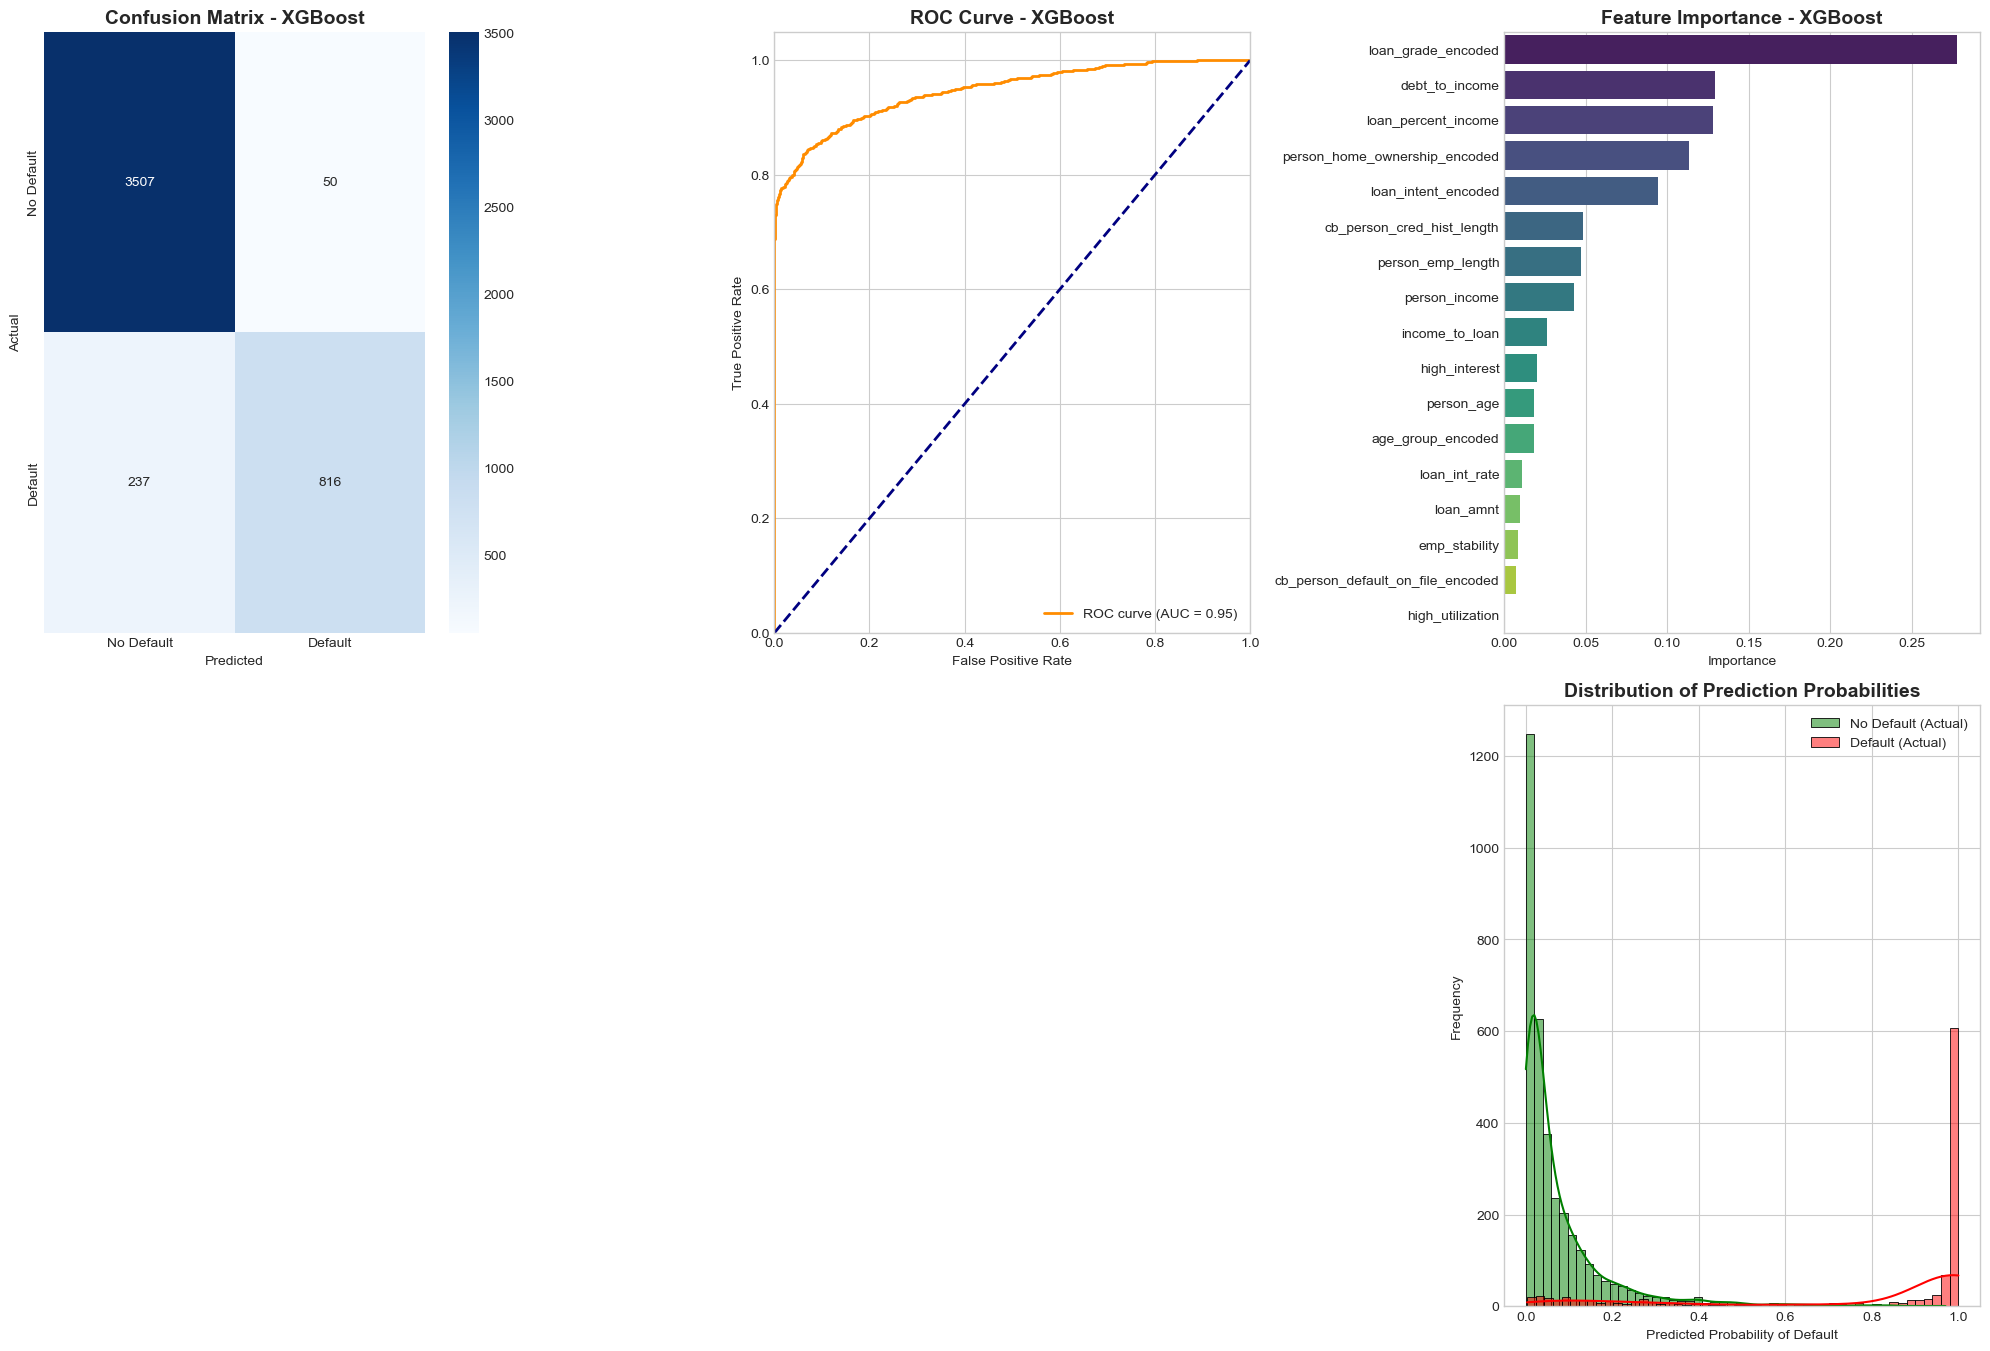

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, classification_report
import numpy as np

# 10. VISUALIZATIONS
# ============================================================================

# Set style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

fig = plt.figure(figsize=(20, 20))

# Get the best model and its predictions
best_model_name = max(results, key=lambda x: results[x]['roc_auc'])
best_model_data = results[best_model_name]
model = best_model_data['model']
y_pred = best_model_data['y_pred']
y_pred_proba = best_model_data['y_pred_proba']

# 1. Confusion Matrix
ax1 = plt.subplot(3, 3, 1)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax1,
            xticklabels=['No Default', 'Default'],
            yticklabels=['No Default', 'Default'])
ax1.set_title(f'Confusion Matrix - {best_model_name}', fontsize=14, fontweight='bold')
ax1.set_xlabel('Predicted')
ax1.set_ylabel('Actual')

# 2. ROC Curve
ax2 = plt.subplot(3, 3, 2)
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)
ax2.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
ax2.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
ax2.set_xlim([0.0, 1.0])
ax2.set_ylim([0.0, 1.05])
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.set_title(f'ROC Curve - {best_model_name}', fontsize=14, fontweight='bold')
ax2.legend(loc="lower right")

# 3. Feature Importance (for Logistic Regression and tree-based models)
ax3 = plt.subplot(3, 3, 3)
if hasattr(model, 'coef_'): # Logistic Regression
    importance = abs(model.coef_[0])
    feature_names_full = X.columns.tolist()
    indices = np.argsort(importance)[::-1]
    sns.barplot(x=importance[indices], y=[feature_names_full[i] for i in indices], ax=ax3, palette='viridis')
    ax3.set_title(f'Feature Importance - {best_model_name}', fontsize=14, fontweight='bold')
    ax3.set_xlabel('Coefficient Magnitude')
elif hasattr(model, 'feature_importances_'): # Tree-based models
    importance = model.feature_importances_
    feature_names_full = X.columns.tolist()
    indices = np.argsort(importance)[::-1]
    sns.barplot(x=importance[indices], y=[feature_names_full[i] for i in indices], ax=ax3, palette='viridis')
    ax3.set_title(f'Feature Importance - {best_model_name}', fontsize=14, fontweight='bold')
    ax3.set_xlabel('Importance')
else:
    ax3.text(0.5, 0.5, 'Feature Importance not available for this model type', horizontalalignment='center', verticalalignment='center', transform=ax3.transAxes)


# 6. Prediction Probabilities Distribution
ax6 = plt.subplot(3, 3, 6)
sns.histplot(y_pred_proba[y_test == 0], bins=50, color='green', label='No Default (Actual)', kde=True, ax=ax6)
sns.histplot(y_pred_proba[y_test == 1], bins=50, color='red', label='Default (Actual)', kde=True, ax=ax6)
ax6.set_title('Distribution of Prediction Probabilities', fontsize=14, fontweight='bold')
ax6.set_xlabel('Predicted Probability of Default')
ax6.set_ylabel('Frequency')
ax6.legend()

plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd

sample_input = pd.DataFrame([[
    24,      # person_age
    10000,   # person_income
    1,       # person_emp_length
    5000,    # loan_amnt
    12.5,    # loan_int_rate
    0.50,    # loan_percent_income
    3,       # cb_person_cred_hist_length
    0.35,    # debt_to_income
    2.0,     # income_to_loan
    1,       # emp_stability
    0,       # high_interest
    0,       # high_utilization
    1,       # person_home_ownership_encoded
    2,       # loan_intent_encoded
    1,       # loan_grade_encoded
    0,       # cb_person_default_on_file_encoded
    0        # age_group_encoded
]], columns=feature_cols)

prediction = model.predict(sample_input)
prediction


array([1])

In [ ]:
import numpy as np

sample_input = np.array([[
    24,      # person_age
    10000,   # person_income
    1,       # person_emp_length
    5000,    # loan_amnt
    12.5,    # loan_int_rate
    0.50,    # loan_percent_income
    3,       # cb_person_cred_hist_length
    0.35,    # debt_to_income
    2.0,     # income_to_loan
    1,       # emp_stability
    0,       # high_interest
    0,       # high_utilization
    1,       # person_home_ownership_encoded
    2,       # loan_intent_encoded
    1,       # loan_grade_encoded
    0,       # cb_person_default_on_file_encoded
    0        # age_group_encoded
]])

prediction = model.predict(sample_input)
prediction


array([1])